In [1]:
import os.path
import seaborn as sns
from math import floor
import parameter
import query
import time
import copy
import pickle
from model import Model
from station import Station
import numpy as np
import pandas as pd
from datetime import datetime , timedelta
import matplotlib.pyplot as plt

In [2]:
# parameter.get_station_information(True)
def get_state(path: str) -> {str: Station}:
    df = pd.read_csv(path)
    stations_dict = {}
    for i in range(len(df)):
        stations_dict[df.loc[i, 'name']] = (
            Station(name=df.loc[i, 'name'],
                    lat=df.loc[i, 'lat'],
                    lon=df.loc[i, 'lon'],
                    max_docks=df.loc[i, 'capacity'],
                    curr_bikes=df.loc[i, 'num_bikes_available'],
                    rate=[],
                    transition=[],
                    id=0,
                    neighbors_dist={},
                    neighbors_names=[]))
    return stations_dict

def mean_sq_error(stations_dict=None, other_stations=None, path=None):
    if other_stations is None and path is None:
        print("No comparison stations provided")
        return
    if other_stations is None:
        other_stations = get_state(path)
    error = 0
    for station in stations_dict:
        error += (stations_dict[station].curr_bikes - other_stations[station].curr_bikes) ** 2
    return error / len(stations_dict)

In [3]:
stations = pd.read_csv('data/stations.csv', index_col=0)
tph = 4
path = f'data/station_data/test_whitelist/v1/tph_{tph}/'
if not os.path.exists(path):
    os.makedirs(path)
    
station_information = pd.read_csv('data/station_data/status_at_time/2024_6_18_10:4.csv', index_col=0)
whitelist = []
for station in stations['station_name']:
    if station in station_information['name'].values:
        if station_information.loc[station_information['name'] == station, 'operating'].values[0]:
            whitelist.append(station)

# whitelist = ['Allen St & Rivington St', 'Allen St & Stanton St', '1 Ave & E 16 St', 'Mercer St & Spring St', 'Mercer St & Bleecker St', '9 Ave & W 18 St', 'E 103 St & Lexington Ave', '1 Ave & E 6 St', 'Norfolk St & Broome St', 'E 1 St & 1 Ave', 'S 4 St & Wythe Ave', 'Lafayette St & Jersey St', 'Broadway & Berry St', 'S 5 Pl & S 5 St', 'E 5 St & Cooper Sq', 'Howard St & Lafayette St', 'E 32 St & Park Ave', 'Greenwich St & Hubert St', 'W 27 St & 7 Ave', 'Vesey Pl & River Terrace']

total_stations = len(whitelist)
done_stations = 0  

station_list = {}
start_date = query.get_datetime(2024, 5, 1, 0, 0, 0)
end_date = query.get_datetime(2024, 5, 30, 0, 0, 0)
# for station in whitelist[done_stations:]:
#     station_list[station] = parameter.get_station(station, station_information = station_information,
#                                                   start_date=start_date, end_date=end_date, whitelist=whitelist, tph=tph)
#     parameter.pickle_station(station_list[station], path)
#     done_stations += 1
#     if done_stations % 10 == 0:
#         print(f'{done_stations}/{total_stations} done')

In [4]:
pickle_dir = f'data/station_data/test_whitelist/v1/tph_{4}/'
origin_path = 'data/station_data/status_at_time/2024_6_17_14:6.csv'
end_path = 'data/station_data/status_at_time/2024_6_17_15:5.csv'

origin_state = get_state(origin_path)
end_state = get_state(end_path)
tph = 12

with open('data/station_data/2024 model/v1/all_stations_tph_4.pickle', 'rb') as f:
    station_list = pickle.load(f)

for station in station_list:
    if station not in whitelist:
        station_list.remove(station)
        

for station in whitelist:
#     station_list[station] = parameter.get_pickle_station(station, pickle_dir)
    station_list[station].refine_by_3()

model = Model(station_names=whitelist, stations_dict=station_list, in_transit=[], tph=tph)
model.init_state(path=origin_path, time=timedelta(hours=14))
print(model.mean_sq_error(other_stations=origin_state))
print(model.mean_sq_error(other_stations=end_state))

# model.truncate_transitions()


0.0
9.431558935361217


In [16]:
model.sim()
station_bikes = 0
for station in model.stations_dict.values():
    print(station.name, 'has', station.curr_bikes, 'bikes')
    station_bikes += station.curr_bikes
print(len(model.in_transit), 'bikes in transit')
print(station_bikes, 'station bikes')
print(len(model.in_transit)+station_bikes, 'total bikes')
print('time:', model.curr_time, 'total_trips:', model.total_trips, 'failures:', model.failures)
print(f'Origin to end state: {model.mean_sq_error(stations_dict=origin_state, other_stations=end_state)}')
print(f'Origin to model state: {model.mean_sq_error(other_stations=origin_state)}')
print(f'Model state to end state: {model.mean_sq_error(other_stations=end_state)}')

E 11 St & 1 Ave has 32 bikes
Crotona Ave & E 179 St has 9 bikes
50 St & 7 Ave has 4 bikes
Broadway & 12 St has 23 bikes
24 Ave & 26 St has 9 bikes
5 Av & W 139 St has 2 bikes
Bergen St & Troy Ave has 12 bikes
E 180 St & Monterey Ave has 5 bikes
E 58 St & 1 Ave (NW Corner) has 22 bikes
Fulton Ave & E 172 St has 1 bikes
Sterling Pl & Bedford Ave has 0 bikes
South Railroad Ave & Broadway has 13 bikes
Rutland Rd & E 45 St has 15 bikes
36 St & Hunters Point Ave has 12 bikes
Laight St & Hudson St has 42 bikes
34 Ave & 13 St has 17 bikes
Greenwich St & Perry St has 6 bikes
Bedford Ave & Clarkson Ave has 13 bikes
McKibbin St & Manhattan Ave has 0 bikes
Wallabout St & Kent Ave has 3 bikes
Brooklyn Ave & Tilden Ave has 24 bikes
Old Broadway & W 133 St has 0 bikes
Menahan St & Central Ave has 8 bikes
W 22 St & 8 Ave has 12 bikes
Decatur Ave & Bedford Park Blvd has 14 bikes
35 Ave & 37 St has 20 bikes
Central Ave & Melrose St has 6 bikes
Warren St & Smith St has 30 bikes
W Broadway & W Houston St 

In [19]:
model.sim_trips()
print(f'Origin to end state: {model.mean_sq_error(stations_dict=origin_state, other_stations=end_state)}')
print(f'Origin to model state: {model.mean_sq_error(other_stations=origin_state)}')
print(f'Model state to end state: {model.mean_sq_error(other_stations=end_state)}')

Origin to model state: 3.107889733840304
Model state to end state: 11.009030418250951
Origin to end state: 9.094399277326106


In [17]:
def cluster_stations(stations_dict, square_length: float):
    lat_min = np.inf
    lat_max = -np.inf
    lon_min = np.inf
    lon_max = -np.inf
    for station in stations_dict.values():
        if station.lat < lat_min:
            lat_min = station.lat
        if station.lat > lat_max:
            lat_max = station.lat
        if station.lon < lon_min:
            lon_min = station.lon
        if station.lon > lon_max:
            lon_max = station.lon
    vertical_squares  = int((lat_max - lat_min) / square_length) + 1
    horizontal_squares = int((lon_max - lon_min) / square_length) + 1
    squares = horizontal_squares * vertical_squares
    print(
        f'{horizontal_squares} horizontal squares and {vertical_squares} vertical squares. Total squares: {squares}')
    clusters = [[] for square in range(squares)]
    for station in stations_dict.values():
        x = floor((station.lon - lon_min) / square_length)
        y = -floor((station.lat - lat_min) / square_length) - 1
        clusters[x + y * horizontal_squares].append(station.name)

    return horizontal_squares, vertical_squares, clusters

In [45]:
horizontal_squares, vertical_squares, model_clusters = model.cluster_stations(0.004)
# i, j, origin_clusters = cluster_stations(end_state, 0.004)
# i, j, end_clusters = cluster_stations(origin_state, 0.004)

num_stations = []
num_bikes_model = []
num_bikes_origin = []
num_bikes_end = []
for y in range(vertical_squares):
    num_stations.append([len(stations) for stations in model_clusters[y * horizontal_squares:(y + 1) * horizontal_squares]])
    num_bikes_model.append([sum([model.stations_dict[station].curr_bikes for station in stations]) for stations in model_clusters[y * horizontal_squares:(y + 1) * horizontal_squares]])
    num_bikes_origin.append([sum([origin_state[station].curr_bikes for station in stations]) for stations in model_clusters[y * horizontal_squares:(y + 1) * horizontal_squares]])
    num_bikes_end.append([sum([end_state[station].curr_bikes for station in stations]) for stations in model_clusters[y * horizontal_squares:(y + 1) * horizontal_squares]])

52 horizontal squares and 64 vertical squares. Total squares: 3328


In [46]:
num_stations = np.array(num_stations)
num_bikes_model = np.array(num_bikes_model)
num_bikes_origin = np.array(num_bikes_origin)
num_bikes_end = np.array(num_bikes_end)

In [50]:
valid_clusters = 0
mape_model_to_end = 0
mape_origin_to_end = 0
mape_origin_to_model = 0

for i in range(vertical_squares):
    for j in range(horizontal_squares):
        if num_stations[i, j] > 0:
            valid_clusters += 1
        if num_bikes_end[i, j] > 0:
            mape_model_to_end += abs(num_bikes_end[i, j] - num_bikes_model[i, j])/num_bikes_end[i, j]
            mape_origin_to_end += abs(num_bikes_end[i, j] - num_bikes_origin[i, j])/num_bikes_end[i, j]
        if num_bikes_origin[i, j] > 0:
            mape_origin_to_model += abs(num_bikes_model[i, j] - num_bikes_origin[i, j])/num_bikes_origin[i, j]

origin_dif = (num_bikes_origin - num_bikes_end)**2
model_dif = (num_bikes_model - num_bikes_end)**2
drift_dif = (num_bikes_model - num_bikes_origin)**2


In [51]:
print(f'No pred Mean Squared Error: {np.sum(origin_dif) / valid_clusters}')
print(f'Mean Squared Error: {np.sum(model_dif) / valid_clusters}')
print(f'Drift Mean Squared Error: {np.sum(drift_dif) / valid_clusters}')

print(f'Mean Absolute Percent Error model to end: {mape_model_to_end / valid_clusters}')
print(f'Mean Absolute Percent Error origin to end: {mape_origin_to_end / valid_clusters}')
print(f'Mean Absolute Percent Error origin to model: {mape_origin_to_model / valid_clusters}')

No pred Mean Squared Error: 19.36219816819317
Mean Squared Error: 18.560366361365528
Drift Mean Squared Error: 5.581182348043297
Mean Absolute Percent Error model to end: 0.2589817639189648
Mean Absolute Percent Error origin to end: 0.232264222542237
Mean Absolute Percent Error origin to model: 0.1211930263368787


<Axes: >

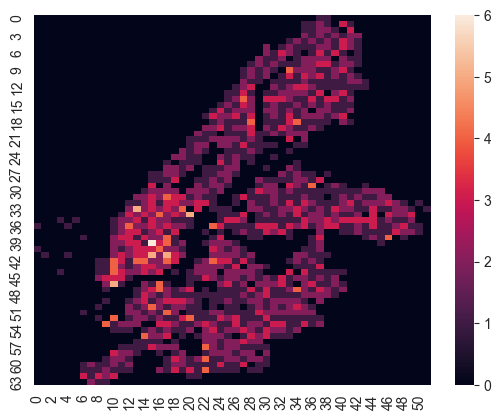

In [31]:
sns.heatmap(num_stations)

<Axes: >

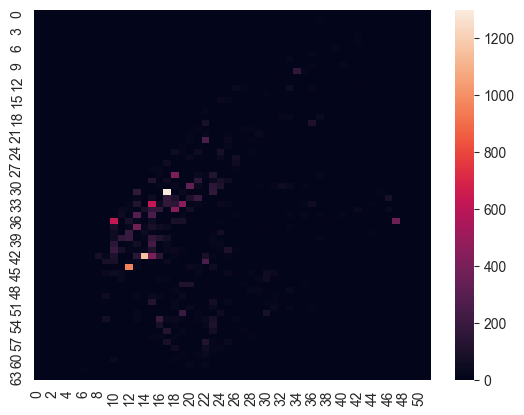

In [24]:
sns.heatmap(model_dif)

<Axes: >

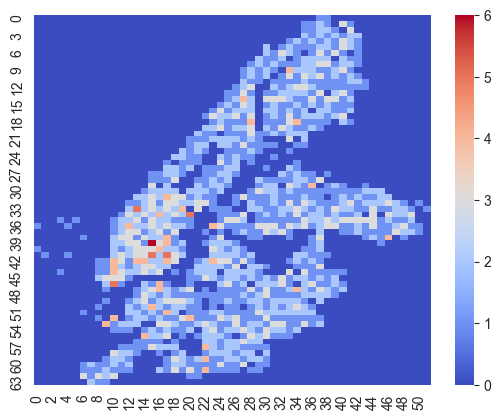

In [22]:
sns.heatmap(num_stations, cmap='coolwarm')

In [20]:
num_stations

[]

<Axes: >

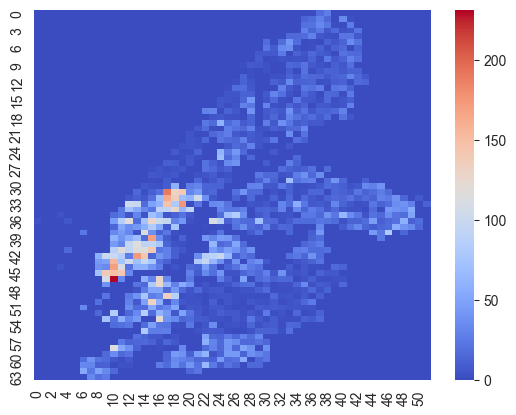

In [17]:
sns.heatmap(num_bikes_end, cmap='coolwarm')

<Axes: >

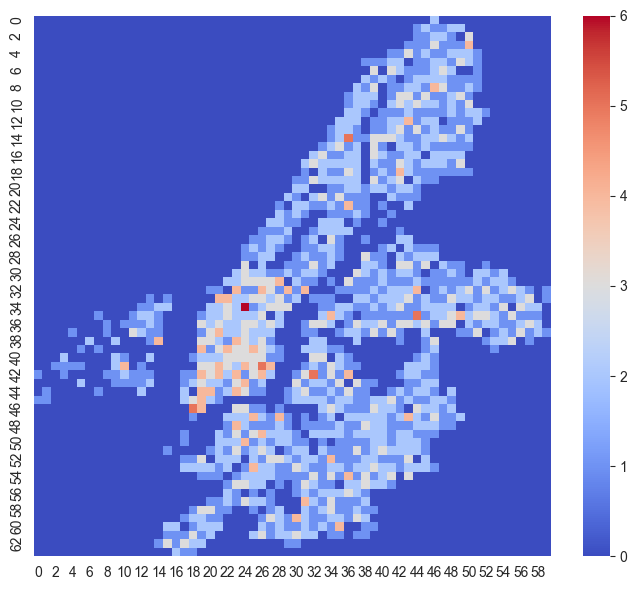

In [111]:
plt.subplots(figsize=(7,6))
sns.heatmap(num_stations, cmap='coolwarm')

Axes(0.0553175,0.064537;0.738603x0.901296)


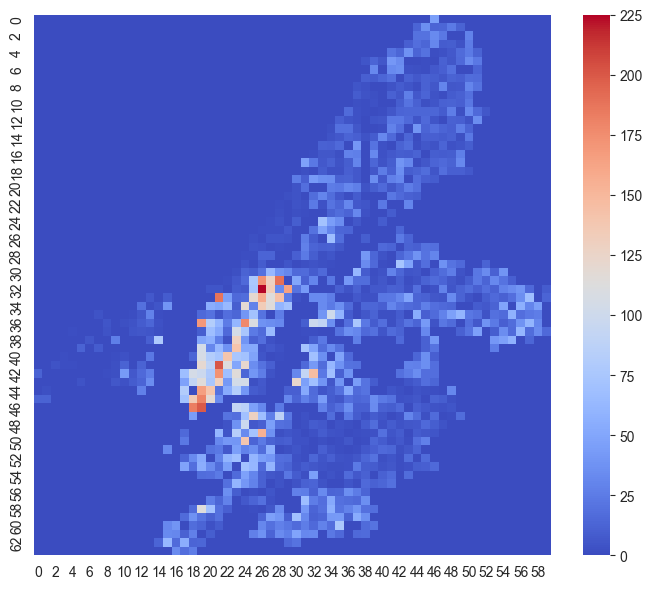

In [110]:
plt.subplots(figsize=(7,6))
print(sns.heatmap(num_bikes, cmap='coolwarm'))


In [93]:
origin_state = get_state(origin_path)
end_state = get_state(end_path)
origin_df = pd.DataFrame(origin_state.keys(), columns=['station'])
end_df = pd.DataFrame(end_state.keys(), columns=['station'])

origin_df['bikes'] = [origin_state[station].curr_bikes for station in origin_df['station']]
origin_df['cluster'] = 0
for i in range(len(clusters)):
    for station in clusters[i]:
        origin_df.loc[origin_df['station'] == station, 'cluster'] = i
# origin_df = origin_df.sort_values(by='cluster')
origin_df['frame'] = 1

end_df['bikes'] = [origin_state[station].curr_bikes for station in end_df['station']]
end_df['cluster'] = 0
for i in range(len(clusters)):
    for station in clusters[i]:
        end_df.loc[end_df['station'] == station, 'cluster'] = i
# end_df = end_df.sort_values(by='cluster')
end_df['frame'] = 2
